# Non Negative Matrix Factorisation

The purpose of this project will be to explore a Non Negative Matrix Factorisation (NMF) algorithm from scratch. The algorithm will consist of a euclidean and kl-divergence cost function optimised using a multiplicative update approach. My efforts in this project were part of the coursework of Advanced Machine Learning from the Master of Data Science offered by the University of Sydney. Throughout this notebook, I will paste snippets of the report that I wrote in collaboration with my assignment partner Joshua Huang.

Key achievements:
1. Investigated and wrote a Non Negative Matrix Factorisation algorithm from scratch.
2. First time working with images in a machine learning application.
 

Over the last few decades, Non-Negative Matrix Factorisation (NMF) has been demonstrated as a potential unsupervised learning and decomposition technique that can be used across a wide range of applications including image recognition, speech recognition and natural language processing. The major difference between NMF and other matrix decomposition algorithms is that all matrices involved in NMF are required to be non-negative. This is a reasonable constraint as many observations in the physical world are represented by non-negative numbers. As with all machine learning algorithms however, NMF has been found to perform differently depending on the underlying application, with one specific variable being the distribution of noise present in the data. Consequently, a number of researchers in the field have proposed various modifications to NMF, namely through the use of different cost functions and optimisation procedures. 

This project thus aims to validate the robustness of the standard NMF algorithms which use the squared Euclidean distance and Kullback-Leibler divergence cost function to different types of noise. Specifically, the importance of pre-processing and robustness to noise generated from a Gaussian and Laplacian distribution will be investigated. The datasets used for experimentation will consist of the ORL and YaleB dataset. All experimentation scenarios will be applied to both datasets and evaluated using three different robustness metrics (Relative Reconstruction Errors, Average Accuracy and Normalised Mutual Information) on each algorithm’s performance. 

The notebook will use two image datasets - CroppedYaleB and ORL. 

CroppedYaleB can be found here:
http://vision.ucsd.edu/~leekc/ExtYaleDatabase/ExtYaleB.html

and ORL here:
http://www.cl.cam.ac.uk/Research/DTG/attarchive:pub/data/att_faces.zip

Sample image from ORL dataset:


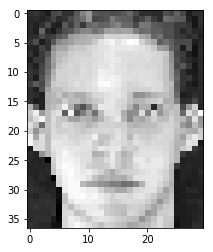

In [19]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import random
import datetime

#functions for loading the image datasets

def load_data(root='C:/Users/Harrison/Documents/Uni Work/Advanced Machine Learning/data/CroppedYaleB', reduce=4):
    images, labels = [], []
    for i, person in enumerate(sorted(os.listdir(root))):
        if not os.path.isdir(os.path.join(root, person)):
            continue        
        for fname in os.listdir(os.path.join(root, person)):  
            # Remove background images in Extended YaleB dataset.
            if fname.endswith('Ambient.pgm'):
                continue            
            if not fname.endswith('.pgm'):
                continue                
            # load image.
            img = Image.open(os.path.join(root, person, fname))
            img = img.convert('L') # grey image.
            # reduce computation complexity.
            img = img.resize([s//reduce for s in img.size])
            # preprocessing (normalisation)
            img = (img-np.min(img))/(np.max(img)-np.min(img))
            # convert image to numpy array.
            img = np.asarray(img).reshape((-1,1))           
            # collect data and label.
            images.append(img)
            labels.append(i)
    # concate all images and labels.
    images = np.concatenate(images, axis=1)
    labels = np.array(labels)
    return images, labels

def load_data_without_normalisation(root='C:/Users/Harrison/Documents/Uni Work/Advanced Machine Learning/data/CroppedYaleB', reduce=4):
    images, labels = [], []
    for i, person in enumerate(sorted(os.listdir(root))):
        if not os.path.isdir(os.path.join(root, person)):
            continue        
        for fname in os.listdir(os.path.join(root, person)):  
            # Remove background images in Extended YaleB dataset.
            if fname.endswith('Ambient.pgm'):
                continue            
            if not fname.endswith('.pgm'):
                continue                
            # load image.
            img = Image.open(os.path.join(root, person, fname))
            img = img.convert('L') # grey image.
            # reduce computation complexity.
            img = img.resize([s//reduce for s in img.size])
            # preprocessing (normalisation)
            img = (img-np.min(img))/(np.max(img)-np.min(img))
            # convert image to numpy array.
            img = np.asarray(img).reshape((-1,1))           
            # collect data and label.
            images.append(img)
            labels.append(i)
    # concate all images and labels.
    images = np.concatenate(images, axis=1)
    labels = np.array(labels)
    return images, labels

#Sample images from both datasets
V_orl, Y = load_data(root='C:/Users/Harrison/Documents/Uni Work/Advanced Machine Learning/Assignment 1/data/ORL', reduce=3)
#print('ORL dataset: X.shape = {}, Y.shape = {}'.format(V.shape, Y.shape))  #reshape numbers: 37, 30

image_original = V_orl[:,0].reshape(37,30)
plt.imshow(image_original, cmap=plt.cm.gray)
print('Sample image from ORL dataset:')

Sample image from Yale dataset


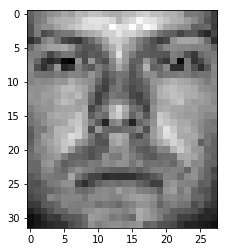

In [18]:
#load the YaleB Database
V_yale, Y = load_data(root='C:/Users/Harrison/Documents/Uni Work/Advanced Machine Learning/Assignment 1/data/CroppedYaleB', reduce=6)
#print('Extended YalB dataset: X.shape = {}, Y.shape = {}'.format(V.shape, Y.shape)) #reshape numbers 32, 28

image_original = V_yale[:,0].reshape(32,28)
plt.imshow(image_original, cmap=plt.cm.gray)
print('Sample image from Yale dataset:')

The functions below are Non Negative Matrix Factorisation algorithms written using standard squared Euclidean distance and KL Divergence cost functions. The multiplicative update rules are written to gaurantee optimisation. According to the academic literature, Euclidean NMF is more robust against gaussian noise and less robust against laplacian compared to KL-Divergence NMF.

In [22]:
#function for NMF using a euclidean based cost function and a multiplicative update algorithm

def NMF_euc(V, max_iterations):
    n = V.shape[0]
    m = V.shape[1]
    r = np.linalg.matrix_rank(V)
    W = np.random.rand(n, r)
    H = np.random.rand(r, m)        
    records = []
    iteration_count = 0
    conv_criteria = []
    stop_flag = 0
#stop criteria maxes at specified max_iterations or when ratio of the
#difference in loss is between 0.99 and 1 for last 20 iterations(i.e. convergence)
    while iteration_count < max_iterations and stop_flag != 1:
        W_stationary = W
        H_stationary = H
        top_H = np.dot(W_stationary.T, V)
        bottom_H = W_stationary.T.dot(np.dot(W_stationary, H_stationary))
        for i in range(H.shape[0]):
            for j in range(H.shape[1]):
                H[i][j] = H_stationary[i][j] * top_H[i][j] / bottom_H[i][j]  
        H_stationary = H
        W_stationary = W
        top_W = np.dot(V, H_stationary.T)
        bottom_W = W_stationary.dot(np.dot(H_stationary, H_stationary.T))
        for i in range(W.shape[0]):
            for j in range(W.shape[1]):
                W[i][j] = W_stationary[i][j] * top_W[i][j] / bottom_W[i][j]
        loss = np.sum((V - W.dot(H))**2)   
        records.append(loss)
        iteration_count += 1
        ##print('Iteration %s: %s' %(iteration_count, loss))
        if iteration_count > 100:
            try:
                conv_1 = abs(records[-2] - records[-1])
                conv_2 = abs(records[-3] - records[-2])
                convergence_value = conv_1/conv_2
                conv_criteria.append (convergence_value)
                last_20_1 = np.array(conv_criteria[-20:]) > 0.99 
                last_20_2 = np.array(conv_criteria[-20:]) < 1  
                if np.sum(last_20_1) == np.sum(last_20_2):
                    stop_flag = 1
                else:
                    stop_flag = 0
            except:
                next
    return W,H

#KL Divergence NMF
def NMF_div(V, max_iterations):
    n = V.shape[0]
    m = V.shape[1]
    r = np.linalg.matrix_rank(V)
    W = np.random.rand(n, r)
    H = np.random.rand(r, m)        
    records = []
    iteration_count = 0
    conv_criteria = []
    stop_flag = 0
    while iteration_count < max_iterations and stop_flag != 1:
        W_stationary = W
        H_stationary = H
        top_H = W_stationary.T.dot(V/np.dot(W_stationary, H_stationary))
        bottom_H = np.dot(W_stationary.T, np.ones(V.shape))
        for i in range(H.shape[0]):
            for j in range(H.shape[1]):
                H[i][j] = H_stationary[i][j] * top_H[i][j] / bottom_H[i][j]  
        H_stationary = H
        W_stationary = W
        top_W = np.dot((V/np.dot(W_stationary, H_stationary)), H_stationary.T)
        bottom_W = np.dot(np.ones(V.shape),H_stationary.T)
        for i in range(W.shape[0]):
            for j in range(W.shape[1]):
                W[i][j] = W_stationary[i][j] * top_W[i][j] / bottom_W[i][j]
        z = V/(np.dot(W,H))
        z[z<=0] = 0.001
        loss = np.sum(V*np.log(z) - V + W.dot(H))
        records.append(loss)
        iteration_count += 1
        #print(loss)
        if iteration_count > 100:
            try:
                conv_1 = abs(records[-2] - records[-1])
                conv_2 = abs(records[-3] - records[-2])
                convergence_value = conv_1/conv_2
                conv_criteria.append (convergence_value)
                last_20_1 = np.array(conv_criteria[-20:]) > 0.99 
                last_20_2 = np.array(conv_criteria[-20:]) < 1  
                if np.sum(last_20_1) == np.sum(last_20_2):
                    stop_flag = 1
                else:
                    stop_flag = 0
            except:
                next
    return W,H

In [23]:
#These functions will be used to measure the robustness of each algorithm i.e robustness evaluation metrics (accuracy,
#relative reconstruction errors (RRE) and Normalised Mutual Information (NMI).

from collections import Counter
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.metrics import normalized_mutual_info_score

def assign_cluster_label(X, Y):
    kmeans = KMeans(n_clusters=len(set(Y))).fit(X)
    Y_pred = np.zeros(Y.shape)
    for i in set(kmeans.labels_):
        ind = kmeans.labels_ == i
        Y_pred[ind] = Counter(Y[ind]).most_common(1)[0][0] # assign label.
    return Y_pred

#kmeans = KMeans(n_clusters=len(set(Y))).fit(V_recon.T)

#Y_pred = assign_cluster_label(np.dot(W,H).T,Y)
#acc = accuracy_score(Y, Y_pred)

###Relative reconstruction errors (RRE)
#RRE = np.linalg.norm(V-np.dot(W, H)) / np.linalg.norm(V)

###NMI
#nmi = normalized_mutual_info_score(Y, Y_pred)

To investigate the differences between Euclidean Distance and KL Divergence NMF, different types of noise will be added to the images in both datasets. The noises used in this experiment will include gaussian, laplacian and sparse noise. Please see below:

<img src="/files/Different Noises.png">

In [24]:
#Noise functions

def add_gaussian_noise(V, mean, std_dev):
    V_noise = np.ones(V.shape)
    for column in range(V.shape[1]):
        gaussian_noise = np.random.normal(mean, std_dev, V.shape[0])
        gaussian_noise[gaussian_noise<0] = 0
        V_noise[:,column] = V[:,column] + gaussian_noise        
    V_noise[V_noise<0] = 0
    return V_noise
        
def add_laplac_noise(V, centre, scale):
    laplac_noise = np.random.laplace(centre,scale,V.shape)
    laplac_noise[laplac_noise<0] = 0
    V_noise = V + laplac_noise
    return V_noise

def add_sparse_noise(V, width, height, reshape_1, reshape_2):
    V_noise = []
    for image in range(V.shape[1]):
        img = V[:, image].reshape(reshape_1,reshape_2)
        start_x = np.random.randint(0, reshape_2 - width)
        start_y = np.random.randint(0, reshape_1 - height)
        img[start_y: start_y+height, start_x:start_x+width] = 1
        img = np.asarray(img).reshape((-1,1))
        V_noise.append(img)
    V_noise = np.concatenate(V_noise, axis=1)
    return V_noise

The code below can be described as three separate experiments. Each experiment will add a different type of noise to the dataset (Gaussian, Laplacian and Sparse* respectively) and measure the robustness of the algorithm against RRE, Accuracy and NMI. Within each experiment, the algorithm will be run 5 times and each metric will then be averaged and recorded.

Each code will have the optional functions commented out. Feel free to activate them as appropriate. The commented-out code will include:
1) Reading in the different datasets (ORL or YALEB)
2) Switching between Euclidean or Divergence NMF algorithms
3) Adding different types of noise (Gaussian, Laplacian and Sparse)

In [32]:
#load the ORL Database
#V, Y = load_data(root='C:/Users/Harrison/Documents/Uni Work/Advanced Machine Learning/Assignment 1/data/ORL', reduce=3)
#print('ORL dataset: X.shape = {}, Y.shape = {}'.format(V.shape, Y.shape))  #reshape numbers: 37, 30

#load the YaleB Database
V, Y = load_data(root='C:/Users/Harrison/Documents/Uni Work/Advanced Machine Learning/Assignment 1/data/CroppedYaleB', reduce=6)
print('Extended YalB dataset: X.shape = {}, Y.shape = {}'.format(V.shape, Y.shape)) #reshape numbers 32, 28

rre_results = []
acc_results = []
nmi_results = []

for i in range(5):       
    #subset = random.sample(range(V.shape[1]), int(0.9*V.shape[1])) #ORL dataset
    subset = random.sample(range(V.shape[1]), int(0.15*V.shape[1])) #YaleB dataset, reduce dataset to reduce computational time
    V_test = V[:, subset]
    Y_test = Y[subset]
        
    #adding noise
    ##gaussian noise
    #V_noise = add_gaussian_noise(V_test, 0, 0.15)
    
    ##laplacian noise
    V_noise = add_laplac_noise(V_test, 0, 0.2)
    
    ##sparse noise
    #V_noise = add_sparse_noise(V_test, 10, 5, 37, 30) #if ORL dataset, using reduce = 3
    #V_noise = add_sparse_noise(V_test, 10, 5, 32, 28 ) #if YaleB dataset, using reduce = 6
    
    #apply NMF
    W, H = NMF_euc(V_noise, 500)
    #W, H = NMF_div(V_noise, 500)
    
    #evaluation metrics
    RRE = np.linalg.norm(V_noise-np.dot(W, H)) / np.linalg.norm(V_noise)
    rre_results.append(RRE)
    
    Y_pred = assign_cluster_label(np.dot(W,H).T,Y_test)
    acc = accuracy_score(Y_test, Y_pred)
    acc_results.append(acc)
    
    nmi = normalized_mutual_info_score(Y_test, Y_pred)
    nmi_results.append(nmi)
    #print(nmi)
    
#evaluate results
rre_mean = np.mean(rre_results)
acc_mean = np.mean(acc_results)
nmi_mean = np.mean(nmi_results)
print("Results:")
print('RRE mean: %s' %(rre_mean))
print('Acc mean: %s' %(acc_mean))
print('NMI mean: %s' %(nmi_mean))

Extended YalB dataset: X.shape = (896, 2414), Y.shape = (2414,)
Results:
RRE mean: 0.1835163305672902
Acc mean: 0.22265193370165748
NMI mean: 0.3487073027375593


The following tables contain the results from the above experiments*:

<img src="/files/ORL_Results.png">

<img src="/files/Yale_Results.png">

*Results are taken from the assignment at the time and therefore may not align with the coded results (experiment was not seeded, my bad!)

Discussion of Results

From the analysis of results, adding noise was seen to have a considerable impact on the performance of both matrix factorization algorithms. Using the no noise metrics as the baseline, Gaussian Noise was seen to have equivalent impact on both Euclidean and KL Divergence NMF, recording an increase of ~0.07 in the RRE value. This is expected as both factorization algorithms perform considerably worse if the Gaussian noise exceeds a certain limit. In the ORL dataset the KL Divergence performed much better with Laplacian noise than the Euclidean distance. This is in stark contrast to the Laplacian noise results from the YaleB dataset, where the KL Divergence performed worse. This could be as a result of the YaleB dataset containing more corruptions than the ORL dataset (where the face is obscured due to poor lightning), or as a consequence of the Laplacian noise that was added separately in each experiment. As the Python algorithm initialized the noise randomly on each experimental iteration, more noise could have been added when testing the YaleB dataset. Furthermore, only 15% of the YaleB dataset was used due to computational reasons compared to the 90% used for the ORL dataset, which could explain the smaller discrepancies observed in YaleB. Both algorithms had similar performance with sparse noise as the noise value was much lower than the Gaussian and Laplacian noise added. 

Thorough analysis of the NMI and ACC also indicate a significant decrease between the dataset scores. As explained above this could be simply due to the structural differences of the data or methodologies used in obtaining the results. Both algorithms also had poor performance with Laplacian noise using these metrics, indicating that the higher noise bounds (greater probability of moderate to extreme outliers due to the distribution’s fatter tails) were more likely to corrupt and affect the algorithm’s performance than Gaussian noise. Sparse noise had a more minor  impact on performance as the quantity of noise was smaller. 

Conclusion

Thorough analysis of the proposed NMF methods have shown that the Euclidean cost metric is relatively on par with the KL Divergence metric. Whilst literature has dictated that KL Divergence is generally meant to be more robust to Gaussian and Laplacian noise, the results obtained within this experiment has proven otherwise. This could be as a result of structural differences between both datasets or due to the initialization method utilized within this experiment. Column-wise normalization was found to have minimal impact however it is likely that multiple experiments need to be conducted to confirm this result. 

The investigations undertaken by this paper have inspired various pathways for future work. This paper only looked at one type of normal and laplacian distribution (i.e. one combination of mean and standard deviation only). Future work would be to perform more experiments using gaussian and laplacian noise, but vary the underlying characteristics of each by shifting the mean and standard deviation or centre and scales respectively. This will give a more robust conclusion to whether Euclidean or KL-divergence performs better on which type of noise. In addition to this, more complex noise, following the idea of sparse noise could also be further investigated in future work. 


In [ ]:
#Appendix for reconstructing the noisy images

#reconstruct images with noise #ORL datasets
image_original = V[:,0].reshape(37,30)
plt.imshow(image_original, cmap=plt.cm.gray)

#noisy_image = V_noise[:,0].reshape(37,30)
plt.imshow(noisy_image, cmap=plt.cm.gray)

#reconstruct images with noise #YaleB datasets
image_original = V_subset[:,0].reshape(32,28) 
plt.imshow(image_original, cmap=plt.cm.gray)

noisy_image = V_noise[:,0].reshape(32,28)
plt.imshow(noisy_image, cmap=plt.cm.gray)

#applying R
r = 300
W_final_chop = W_final[:,:r]
H_final_chop = H_final[:r,:]
recon_r = np.dot(W_final_chop, H_final_chop)
noisy_image_r = recon_r[:,0].reshape(37,30)
plt.imshow(noisy_image_r, cmap=plt.cm.gray)